# Lab2: 自动文档摘要
- 抽取式：PageRank，TextRank
- 压缩式
- 生成式：Encoder-Decoder

## Load Data
本实验不太需要当中的data，使用如下测试文本即可

In [1]:
# -*- coding: utf-8 -*-
from os import listdir
import tqdm


# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


# split a document into news story and highlights
def split_story(doc):
    # find first highlight
    index = doc.find('@highlight')
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    return story, highlights


def load_stories(directory, num_stories=-1):
    """load stories
    
    Args:
        directory(str): the path of cnn_stories
        num_stories(int): NUM of stories to use

    Returns:
        all_stories(list): A list of dict, dict contains `story`(str) and `highlights`(a list of str)
    """
    all_stories = list()
    filenames = listdir(directory)
    if num_stories > -1:
        filenames = filenames[:num_stories]

    for name in tqdm.tqdm(filenames):
        filename = directory + '/' + name
        # load document
        doc = load_doc(filename)
        # split into story and highlights
        story, highlights = split_story(doc)
        # store
        all_stories.append({'story': story, 'highlights': highlights})

    return all_stories



# load stories
directory = 'data/cnn_stories_tokenized/'
stories = load_stories(directory, 10000)
print('Loaded Stories %d' % len(stories))

print(stories[4]['story'])
print(stories[4]['highlights'])

100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 930.30it/s]

Loaded Stories 5000
-LRB- CNN -RRB- -- Police arrested another teen Thursday , the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus .

Jose Carlos Montano , 18 , was arrested on charges of felony rape , rape in concert with force , and penetration with a foreign object , said Richmond Police Lt. Mark Gagan .

Montano was arrested Thursday evening in San Pablo , California , a small town about two miles from the city of Richmond , where the crime took place .

Montano , who was held in lieu of $ 1.3 million bail , is accused of taking part in what police said was a 2 1/2 - hour assault on the Richmond High School campus .

Police said as many as 10 people were involved in the rape in a dimly lit back alley at the school , while another 10 people watched without calling 911 .

The victim was taken to the hospital in critical condition , but was released Wednesday .

Four other teenage suspects were arraigned Thursday 

### 分词、分句工具测试

In [2]:
import numpy as np 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')
    
text = "God is Great! I won a lottery."
print(sent_tokenize(text))
print(word_tokenize(text))

['God is Great!', 'I won a lottery.']
['God', 'is', 'Great', '!', 'I', 'won', 'a', 'lottery', '.']


## 抽取式：TextRank
TextRank是基于google的PageRank的一种算法。
- PageRank的基本思想：指向pageA的page越多，说明pageA越重要。算法使用迭代计算pg(short for PageRank score)，值越大越重要，每次迭代：
    $$pg(A) = \sum_{i}\frac{pg(c_i)}{count(c_{ij})}$$
- TextRank：
    + 定义文本单元，为PageRank中的节点
    + 定义文本单元之间的关系，添加成边，也可设置边的权重
    + 之后使用PageRank算法求解即可：求解特征问题 $MP=P$

> [TextRank提取关键词、生成摘要](https://zhuanlan.zhihu.com/p/41091116)

In [67]:
class TextRank():
    def initMatrix(self, text, simThreshold=1e-4):
        self.sentence_list = sent_tokenize(text) 
        self.matSize = len(self.sentence_list) 
        if self.matSize <= 0: 
            return False
        
        self.simMatrix = np.zeros((self.matSize, self.matSize), dtype=np.float64) 
        for i in range(self.matSize):
            for j in range(self.matSize):
                if i==j: 
                    continue
                self.simMatrix[i][j] = self.__calSim(self.sentence_list[i], self.sentence_list[j], simThreshold)
        self.weightSum = np.sum(np.sum(self.simMatrix))
        return True 
    
    def calRank(self, threshold=1e-7, d=0.85):
        self.pg = np.random.rand(self.matSize, 1)
        self.pg /= np.linalg.norm(self.pg, 1) 
        while True: 
            pg_hat = (1-d) + d * np.dot(self.simMatrix.T, self.pg) / self.weightSum  ## 注意除以权重和weightSum
            if np.sum(np.abs(pg_hat-self.pg)) < threshold:
                break
            self.pg = pg_hat
    
    def run(self, text):
        self.initMatrix(text)
        self.calRank()
    
    def getSummary(self, top_n=3):
        idx = np.argsort(tr.pg, axis=0)
        idx = idx[-top_n:]
        idx = [item[0] for item in idx]
        res = []
#         print(idx)
#         print(len(self.sentence_list))
        for i in range(top_n):
            j = top_n - i - 1
            res.append(self.sentence_list[idx[j]])
        return res
    
    def __calSim(self, senA, senB, threshold):
        lenA, lenB = len(senA), len(senB) 
        if lenA <= 1 and lenB <= 1:
            return 0 
        intersection_set = set(word_tokenize(senA)) & set(word_tokenize(senB)) 
        sim = len(intersection_set) / (np.log(lenA) + np.log(lenB)) 
        if sim >= threshold:
            return sim 
        return 0 

In [68]:
from sumeval.metrics.rouge import RougeCalculator
rouge = RougeCalculator(stopwords=True, lang="en")

cnt = 0
# rouge2_sum, rougel_sum = [], [] 
rougel_sum = [] 
for story_dict in stories:
    if cnt % 200 == 0:
        print(cnt) 
    cnt += 1
    story = story_dict["story"]
    highlight = story_dict["highlights"]
    tr = TextRank()
#     tr.run(story) 
    chk = tr.initMatrix(story)
    if not chk:
        continue 
    tr.calRank()

    summary = tr.getSummary(1) 
#     rouge_2 = rouge.rouge_n(summary=summary[0], references=highlight, n=1)
    rouge_1 = rouge.rouge_l(summary=summary[0], references=highlight)
#     rouge2_sum.append(rouge_2) 
    rougel_sum.append(rouge_1)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


#### appendix

In [48]:
print(tr.simMatrix) 

[[0.         0.72965726 0.54590832 0.3127988  0.29921762 0.11757623
  0.10918166 0.62675702 0.76710591 0.49548066 0.19058422 0.19931206
  0.19058422 0.10025654 0.31037058 0.49869603 0.40600093 0.42526467
  0.22721148 0.29444481 0.23624187 0.21984855 0.30242384 0.22648664
  0.39546956 0.62922707 0.50648314 0.31454838 0.57320935 0.47892808
  0.        ]
 [0.72965726 0.         0.51926199 0.29818604 0.38109207 0.33425721
  0.1038524  1.0310513  1.19279064 0.37874431 0.17491607 0.28559136
  0.17491607 0.38297978 0.29597859 0.38109207 0.48439296 0.40502594
  0.32354168 0.65674234 0.3357243  0.31357218 0.9624772  0.21504112
  0.66134054 1.03494996 0.48346546 0.29977555 0.82286591 0.54995495
  0.21263233]
 [0.54590832 0.51926199 0.         0.48450619 0.46023847 0.41840307
  0.12781111 0.50846071 0.54982476 0.45681864 0.25562222 0.11494894
  0.25562222 0.11574863 0.24007115 0.34517886 0.58704786 0.37170548
  0.40174781 0.56473785 0.42070433 0.12882994 0.46593699 0.13341263
  0.34170287 0.61288

In [39]:
story = stories[358]["story"]
highlight = stories[358]["highlights"]
tr = TextRank()
#     tr.run(story) 
chk = tr.initMatrix(story)
if not chk:
    continue 
tr.calRank()



-LRB- CNN -RRB- -- Pemba Sherpa had already reached Camp 1 on Mount Everest when he heard the loud and chilling bang of the avalanche .

He knew his father was behind him on the Khumbu Icefall and ran down the mountain , only to find the devastation of ice , snow and baggage scattered everywhere .

`` I thought he abandoned his load and ran to safety , '' he tells me , almost whispering .

`` But I could not find him amid the commotion at base camp . Then I saw the helicopters , with the bodies on the suspended ropes , and I knew I lost my dad . ''

Ang Tshiring 's body was taken to Lukla , a tourist town where most who embark on a trip to Everest Base Camp start out .

From there , Pemba and his brother carried him home themselves on foot , a trek that took seven hours along the mountain trail .

Unforgiving land of few opportunities

Ang Tshiring , 57 , was a high altitude cook .

For the past 15 years , during the climbing season , he spent one month at Everest Base Camp and one mon

#### accuracy

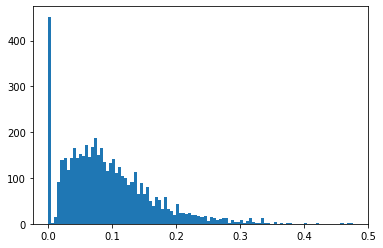

In [74]:
import matplotlib.pyplot as plt 
plt.hist(rougel_sum, bins=100)
plt.show() 

In [72]:
print("rouge_1 average: ", np.sum(rougel_sum) / cnt)
print("rouge_1 max: ", np.max(rougel_sum))
print("rouge_1 min: ", np.min(rougel_sum)) 

rouge_1 average:  0.09151555035403915
rouge_1 max:  0.47619047619047616
rouge_1 min:  0.0


### 使用gensim实现的TextRank工具包：summarize
- 然而，gensim在version 4就没有实现summarize了...
- 需要降级至3.8.3
- 完整代码参考文件`gensim_summary.py`